In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from losses import EnergyScore, KernelScore, VariogramScore
from models import FNO_reparam, FNO_complex

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Subsampling rate
sampling_rate = 2
ntrain = 1500
ntest = 150
batch_size = 64

t1 = 5
t2 = 7
data = np.load("data/ks_1d_data.npy").astype(np.float32)

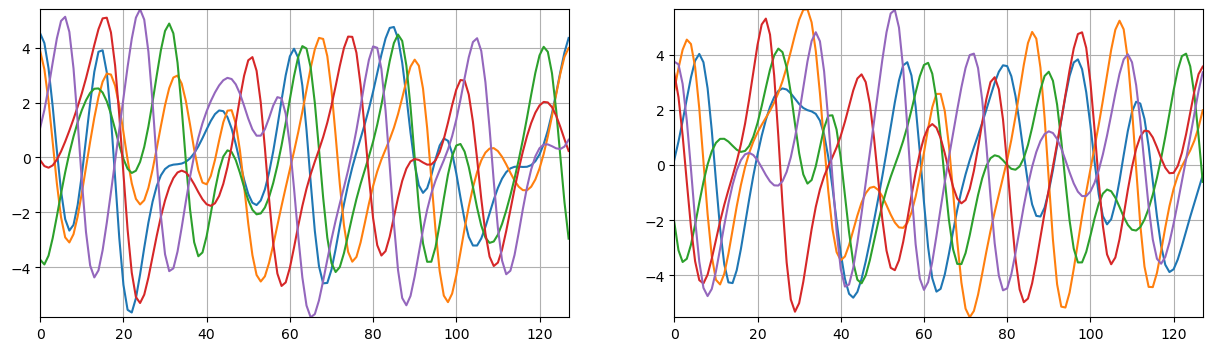

In [3]:
# Example plot
n_samples = np.random.randint(0,ntrain,5)

fig, axs = plt.subplots(1, 2, figsize = (15,4))
index = 0
for i in n_samples:
    axs[0].plot(data[i, t1])
    axs[1].plot(data[i, t2])


axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

In [4]:
grid_range = 1

x_data = torch.tensor(data[:,t1])
y_data = torch.tensor(data[:,t2])
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
size_x = x_data.shape[1]
size_x_train = int(size_x/sampling_rate)

# Add channel dimension
x_data = x_data[:, None, :]
y_data = y_data[:, None, :]

x_train, y_train = x_data[:ntrain,:,::sampling_rate], y_data[:ntrain,:,::sampling_rate]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]

# Add grid
gridx_train = torch.tensor(np.linspace(0, grid_range, size_x_train), dtype=torch.float)
gridx_train = gridx_train.reshape(1, 1, size_x_train)
gridx_test = torch.tensor(np.linspace(0, grid_range, size_x), dtype=torch.float)
gridx_test = gridx_test.reshape(1, 1, size_x)


x_train = torch.cat((x_train, gridx_train.repeat([ntrain, 1, 1])), dim=1)
x_test = torch.cat((x_test, gridx_test.repeat([ntest, 1, 1])), dim=1)

train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

# Losses and parameters

In [5]:
l2loss = LpLoss(d=1, p=2, L = 50.0)
energy_score = EnergyScore(d = 1, p = 2, type = "lp", L = 50.0)
#energy_score = KernelScore(d=1, p=2, type = "lp",  L = 50.0, kernel ="gauss", gamma = 10)
variogram_score = VariogramScore(p=1)

# Training parameters
epochs = 25
learning_rate = 0.001
dropout_rate = 0.1

# MC dropout

In [6]:
def generate_mc_samples(model, x, shape, n_samples=100):
    samples = torch.zeros(*shape, n_samples)
    for i in range(n_samples):
        with torch.no_grad():
            samples[...,i] = model(x).detach()
    return samples

In [7]:
model = FNO(n_modes=(16,), hidden_channels=32, projection_channels=64,
             in_channels = 2, use_mlp=True, mlp_dropout=dropout_rate)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 93537 parameters.


In [8]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [9]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-1.1748, Train-MSE-0.9519, Train-L2-0.9987, Test-L2-1.2044
Epoch-1, Time-1.0032, Train-MSE-0.8599, Train-L2-0.9474, Test-L2-1.1293
Epoch-2, Time-1.0297, Train-MSE-0.7178, Train-L2-0.8621, Test-L2-0.9947
Epoch-3, Time-1.0193, Train-MSE-0.5870, Train-L2-0.7746, Test-L2-0.8605
Epoch-4, Time-1.0100, Train-MSE-0.4680, Train-L2-0.6908, Test-L2-0.7731


KeyboardInterrupt: 

In [ ]:
# %%
model.train()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = generate_mc_samples(model, x, y.shape, n_samples=500)
        pred.append( out )


pred = torch.cat((pred))
mse_dropout = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es_dropout = energy_score(pred, y_test).item()

print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.06022806838154793
ES: 1.1886639595031738


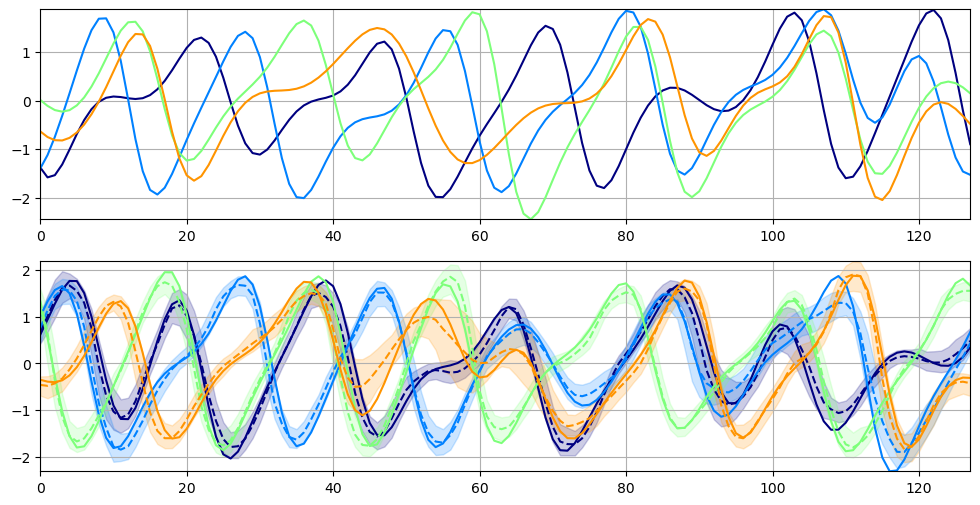

In [ ]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 40 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        # Plot confidence bands
        axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                            pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
        index += 1

axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

# PFNO

In [ ]:
sample_model = FNO_reparam(n_modes=(16,), hidden_channels=32, projection_channels=64, in_channels=2, n_samples = 5,
                           use_mlp=True, mlp_dropout=0)
sample_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

n_params = count_model_params(sample_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 97891 parameters.


In [76]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = sample_model(x)
        
        l2 = energy_score(out,y) 
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = sample_model(x)
            test_l2 += energy_score(out,y).item()

    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-1.4425, Train-L2-0.0789, Test-L2-0.0960
Epoch-1, Time-1.0211, Train-L2-0.0753, Test-L2-0.0918
Epoch-2, Time-1.1963, Train-L2-0.0691, Test-L2-0.0810
Epoch-3, Time-1.4713, Train-L2-0.0608, Test-L2-0.0703
Epoch-4, Time-1.4681, Train-L2-0.0523, Test-L2-0.0617
Epoch-5, Time-1.3598, Train-L2-0.0448, Test-L2-0.0536
Epoch-6, Time-1.6472, Train-L2-0.0391, Test-L2-0.0460
Epoch-7, Time-1.5141, Train-L2-0.0345, Test-L2-0.0408
Epoch-8, Time-1.5959, Train-L2-0.0312, Test-L2-0.0391
Epoch-9, Time-1.7580, Train-L2-0.0285, Test-L2-0.0355
Epoch-10, Time-1.6303, Train-L2-0.0267, Test-L2-0.0330
Epoch-11, Time-1.6655, Train-L2-0.0249, Test-L2-0.0318
Epoch-12, Time-1.5924, Train-L2-0.0231, Test-L2-0.0296
Epoch-13, Time-1.6066, Train-L2-0.0221, Test-L2-0.0290
Epoch-14, Time-1.3959, Train-L2-0.0209, Test-L2-0.0280
Epoch-15, Time-1.4821, Train-L2-0.0202, Test-L2-0.0276
Epoch-16, Time-1.4326, Train-L2-0.0196, Test-L2-0.0272
Epoch-17, Time-1.4060, Train-L2-0.0194, Test-L2-0.0266
Epoch-18, Time-1.521

In [77]:
# %%
sample_model.eval()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = sample_model(x, n_samples = 500).detach().cpu()
        pred.append( out )


pred = torch.cat((pred))
mse = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es = energy_score(pred, y_test).item()

print('MSE:', mse)
print('ES:', es)

MSE: 0.06102894991636276
ES: 1.188805341720581


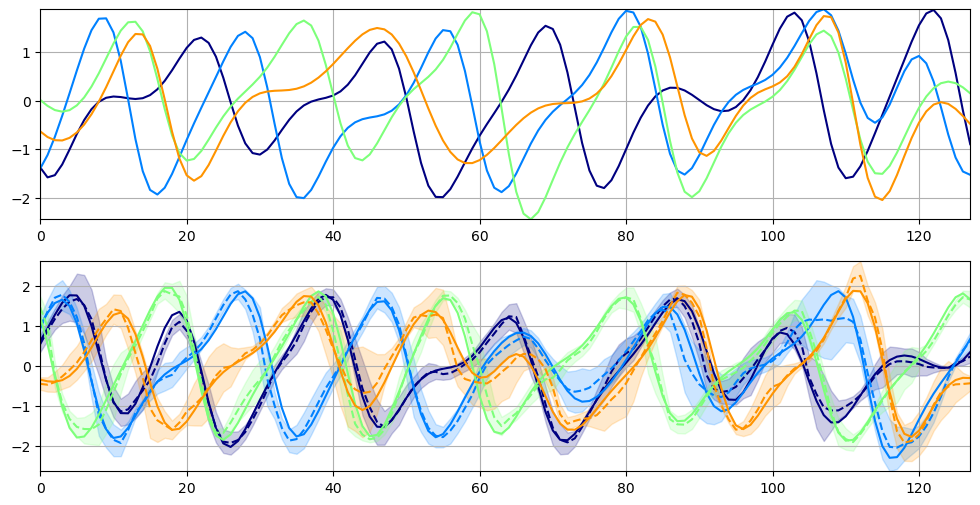

In [78]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 40 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        # Plot confidence bands
        axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                            pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
        index += 1

axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

In [105]:
# Comparison
print('MSE-Dropout:', mse_dropout)
print('ES-Dropout:', es_dropout)

print('MSE:', mse)
print('ES:', es)

MSE-Dropout: 0.06022806838154793
ES-Dropout: 1.1886639595031738
MSE: 0.06102894991636276
ES: 1.188805341720581


# Test complex neural network

In [6]:
def complex_norm(xr, xi, yr, yi, **kwargs):
    """Calculates the complex norm between two tensors

    Args:
        x (Tensor): First tensor of shape (B, n_samples_x, flatted_dims).
        y (Tensor): Second tensor of shape (B, n_samples_y, flatted_dims).

    Returns:
        Tensor: Complex norm norm
    """

    # Restructure tensors to shape (Batch size, n_samples, flatted dims)
   # xr = torch.swapaxes(torch.flatten(xr, start_dim=1, end_dim=-2), 1, 2)
   # xi = torch.swapaxes(torch.flatten(xi, start_dim=1, end_dim=-2), 1, 2)
   # yr = torch.swapaxes(torch.flatten(yr, start_dim=1, end_dim=-2), 1, 2)
   # yi = torch.swapaxes(torch.flatten(yi, start_dim=1, end_dim=-2), 1, 2)

    # Expand dims
    xr = torch.unsqueeze(xr, dim=2)
    xi = torch.unsqueeze(xi, dim = 2)
    yr = torch.unsqueeze(yr, dim=1)
    yi = torch.unsqueeze(yi, dim=1)

    # Calculate dot product
    diff_real = xr - yr
    diff_complex = xi - yi
    norm = torch.sqrt(torch.sum(torch.pow(diff_real,2)+torch.pow(diff_complex,2), dim = -1))

   
    return norm#.mean()

In [11]:
class EnergyScore_complex(object):
    def __init__(self, d = 1, type = "p", reduction = 'mean', reduce_dims = True, **kwargs):
        super().__init__()

        self.d = d
        self.type = type
        self.reduction = reduction
        self.reduce_dims = reduce_dims
        self.p = kwargs.get('p', 2)
        self.norm = complex_norm


    def reduce(self, x):
        if self.reduction == "sum":
            x = torch.sum(x, dim=0, keepdim=True)
        else:
            x = torch.mean(x, dim=0, keepdim=True)
        return x
    
    def calculate_score(self, xr, xi, yr, yi):
        """Calculates the energy score for different metrics

        Args:
            x (_type_): Model prediction (Batch size, ..., n_samples)
            y (_type_): Target (Batch size, ..., 1)
            h (_type_, optional): _description_. Defaults to None.

        Returns:
            _type_: Energy score
        """
        n_samples = xr.size()[-1]

        # Restructure tensors to shape (Batch size, n_samples, flatted dims)
        xr_flat = torch.swapaxes(torch.flatten(xr, start_dim=1, end_dim=-2), 1, 2)
        xi_flat = torch.swapaxes(torch.flatten(xi, start_dim=1, end_dim=-2), 1, 2)
        yr_flat = torch.swapaxes(torch.flatten(yr, start_dim=1, end_dim=-2), 1, 2)
        yi_flat = torch.swapaxes(torch.flatten(yi, start_dim=1, end_dim=-2), 1, 2)


        # Calculate energy score
        term_1 = torch.mean(self.norm(xr_flat, xi_flat, yr_flat, yi_flat), dim=(1,2))
        term_2 = torch.sum(self.norm(xr_flat, xi_flat, xr_flat, xi_flat), dim=(1,2))
        score = term_1# - term_2 / (2 * n_samples * (n_samples - 1))

        # Reduce
        return self.reduce(score).squeeze() if self.reduce_dims else score

    def __call__(self, xr, xi, yr, yi, **kwargs):
        return self.calculate_score(xr, xi, yr, yi, **kwargs)

In [12]:
sample_model = FNO_complex(n_modes=(16,), hidden_channels=32, projection_channels=64, in_channels=2, n_samples = 5,
                           use_mlp=True, mlp_dropout=0, output_type = "complex")
sample_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
energy_score_complex = EnergyScore_complex(d = 1)

n_params = count_model_params(sample_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 171747 parameters.


In [13]:
train_mode = [64]
test_mode = [128]
fft_dims = [-1]
fft_norm = "forward"

In [14]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        y = torch.fft.rfftn(y, dim=fft_dims, norm=fft_norm).unsqueeze(-1)

        optimizer.zero_grad()
        xr, xi = sample_model(x)
  #      xr = xr.mean(axis = -1, keepdim=True)
   #     xi = xi.mean(axis = -1, keepdim = True)
        
        l2 = energy_score_complex(xr, xi, torch.real(y), torch.imag(y)) 
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y = sample["y"].to(device)
            # Transform y
            y = torch.fft.rfftn(y, dim=fft_dims, norm=fft_norm).unsqueeze(-1)

            xr, xi = sample_model(x)
     #       xr = xr.mean(axis = -1, keepdim = True)
      #      xi = xi.mean(axis = -1, keepdim = True)
            test_l2 += energy_score_complex(xr, xi, torch.real(y), torch.imag(y))#.item()


    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-1.0566, Train-L2-0.0112, Test-L2-0.0135
Epoch-1, Time-1.1297, Train-L2-0.0107, Test-L2-0.0130
Epoch-2, Time-1.0676, Train-L2-0.0100, Test-L2-0.0117
Epoch-3, Time-1.0624, Train-L2-0.0089, Test-L2-0.0103
Epoch-4, Time-1.0826, Train-L2-0.0078, Test-L2-0.0089
Epoch-5, Time-1.0979, Train-L2-0.0066, Test-L2-0.0080
Epoch-6, Time-1.1630, Train-L2-0.0056, Test-L2-0.0063


KeyboardInterrupt: 

In [ ]:
# %%
sample_model.eval()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        xr, xi = sample_model(x, n_samples = 500)
        xr = xr.mean(axis = -1, keepdim=True)
        xi = xi.mean(axis = -1, keepdim = True)
        out = torch.complex(xr, xi)
        out = torch.fft.irfftn(out, dim=[-2], norm="forward")
        pred.append( out )


pred = torch.cat((pred))
mse_complex = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
#es_complex = energy_score(pred, y_test).item()

print('MSE:', mse_complex)
#print('ES:', es_complex)

MSE: 0.052548523992300034


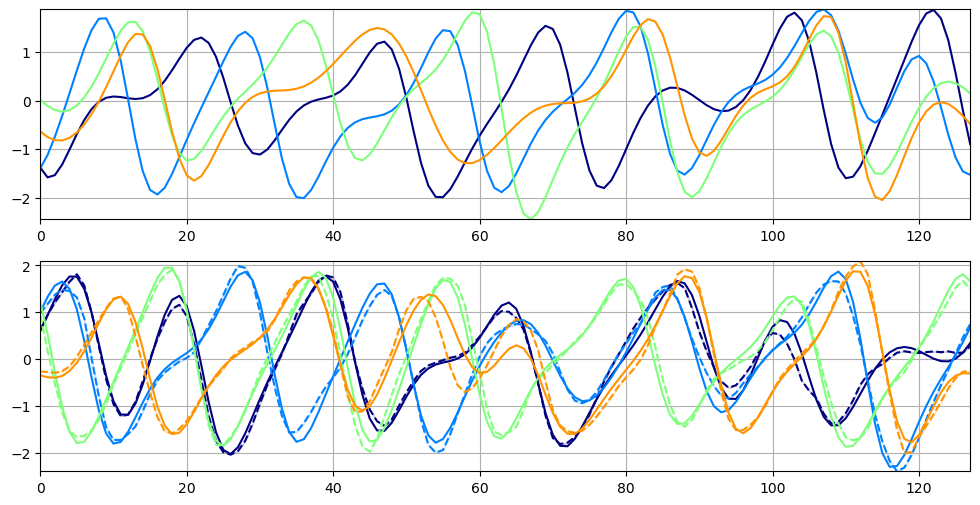

In [86]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 40 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        # Plot confidence bands
        axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                            pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
        index += 1

axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

In [87]:
# Comparison
print('MSE-Dropout:', mse_dropout)
print('ES-Dropout:', es_dropout)

print('MSE:', mse)
print('ES:', es)

print('MSE Complex:', mse_complex)
print('ES Complex:', es_complex)

MSE-Dropout: 0.06022806838154793
ES-Dropout: 1.1886639595031738
MSE: 0.06102894991636276
ES: 1.188805341720581
MSE Complex: 0.052548523992300034


NameError: name 'es_complex' is not defined